# Summary of *Chapter 12: Particle Based Approximate Inference*

This notebook is meant to make the topics discussed in the final week of Coursera's *Probabilistic Graphical Models 2: Inference* more concrete through code examples. This corresponds approximately with chapter 12 of Daphne Koller's book *Probabilistic Graphical Models*. This notebook uses the book as an outline, and not the video lectures. It is recommended you either watch the video lectures or read the chapter to learn the material, and use this notebook as a review sheet.

**Goal**: We have some distribution $P(X)$ and want to estimate the probability of an event $Y = y$, $Y \subseteq X$, $y \in Val(Y)$.

## Method 12.1: Forward Sampling 

Sample directly from $B$, the bayesian network representation of $P$, by sampling from each node's CPD in topological order.

![student network](student_network.png)

Our bayesian network $B$.

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import numpy as np
np.random.seed(0)

# Defining the model structure
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6, 0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7, 0.3]])
cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])
cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])
cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
print("is valid model:", model.check_model())

is valid model: True


In [2]:
from pgmpy.sampling import BayesianModelSampling
forward_sampler = BayesianModelSampling(model)
forward_sampler.forward_sample(size=10)

,I,S,D,G,L
0,0,0,1,1,0
1,1,1,1,1,1
2,0,0,0,1,1
3,0,0,1,2,0
4,0,0,0,0,1
5,0,0,1,2,0
6,0,0,0,1,0
7,1,1,1,1,0
8,1,1,0,1,0
9,0,0,0,1,0


This has the advantage of being simple and samples are independent -- so we may apply the Hoeffding bound to get an absolute bound on the error of our estimate of an expected value for any given variable (or set of variables) in the network. We could alternatively use the Chernoff bound to get a relative bound on the error (But we would need a decent guess of the actual expected value beforehand).

To get an estimate whose error is bounded by $\epsilon$, with probability at least $1-\delta$, we need to draw $M$ samples. Where $M$ satisfies:

$$
M \geq \frac{ln(2/\delta)}{2\epsilon^2}
$$

Assuming we want an error less than or equal to 0.01 with 99% probability, we would need 26,492 samples. Note that we are implicitely assuming that the expected value of our estimate is greater than 0.01 and less than 0.99 (in the binary variable case), otherwise our error bound is too large to be meaningful.

In [3]:
N = 26492
sample_set = forward_sampler.forward_sample(N)

# estimate expected value of the binary variable L(etter)
marginal_estimate = sample_set.loc[:,'L'].sum() / N

# use exact inference to get actual marginal of L
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
marginal_actual = inference.query(['L'])['L']

print("estimate of marginal:", marginal_estimate, sep="\t")
print("actual marginal:", marginal_actual.values[1], sep="\t")
print("difference:", abs(marginal_actual.values[1] - marginal_estimate), sep="\t\t")

estimate of marginal:	0.4976219236
actual marginal:	0.502336
difference:		0.00471407640042


We can visualize the convergence of our estimate to the true expected value.

In [4]:
def track_expectation(sample, variable):
    cumulative_sums = [0]
    for i in range(len(sample)):
        cumulative_sums.append(sample.loc[i,variable] + cumulative_sums[i])
    cumulative_sums = cumulative_sums[1:]
    return np.array([cumulative_sums[i]/(i+1) for i in range(len(cumulative_sums))])

In [5]:
exp_l = track_expectation(sample_set, 'L')

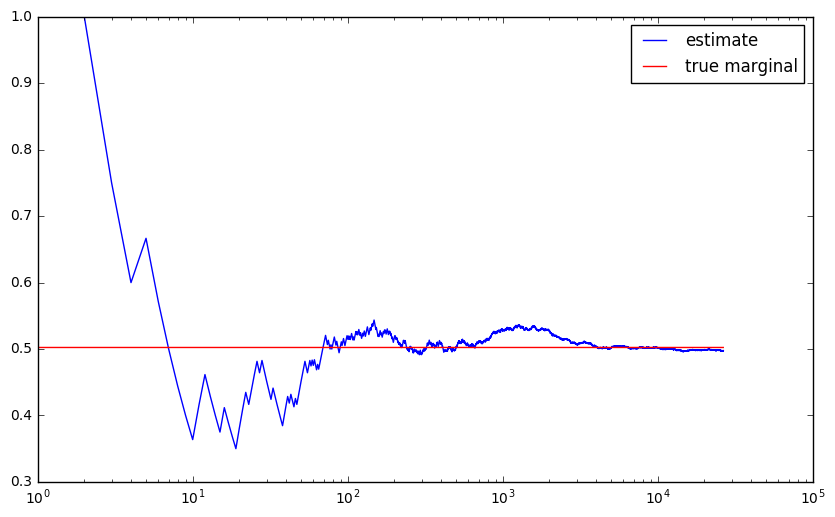

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

domain = np.arange(0, N)
true_value = [marginal_actual.values[1]] * len(domain)
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.plot(domain, exp_l[domain], 'b', domain, true_value, 'r')
plt.legend(["estimate", "true marginal"])

So we can see how useful it is to have probabilistic guarantees as to how erroneous our estimate might be. Even past 1000 samples (a typical size for a national survey) our estimate is still quite bad.

### Method 12.1.1: Rejection Sampling

To estimate a conditional probability given some evidence, $P(Y\,|\,E=e)$, we may use *rejection sampling* where we only consider samples where $E=e$ when computing our estimate.

Suppose we are interested in $E(L\, |\, D=1,\, S=1) = P(L=1\, |\, D=1,\, S=1)$.

Our estimate using the previous sample set would be:

In [7]:
# estimate
valid_samples = sample_set[(sample_set.D == 1) & (sample_set.S == 1)]

marginal_w_evidence_estimate = valid_samples.loc[:,'L'].sum() / len(valid_samples)

# actual
marginal_w_evidence_actual = inference.query(['L'], evidence={'D': 1, 'S': 1})['L']

print("estimate of marginal:", marginal_w_evidence_estimate, sep="\t")
print("actual marginal:", marginal_w_evidence_actual.values[1], sep="\t")
print("difference:", abs(marginal_w_evidence_actual.values[1] - marginal_w_evidence_estimate), sep="\t\t")

estimate of marginal:	0.595613433859
actual marginal:	0.577272727273
difference:		0.0183407065861


Our estimate is now worse than before. This isn't surprising considering we are using fewer samples than previously in our estimate. About 11% of our samples should be consistent with 'D' = 1 and 'S' = 1 ($P(D=1) \times P(S=1)$), so we must draw nearly 10 times as many samples to get the same quality estimate. This might not seem like too much of a problem, but in a larger network with more evidence, where $P(E=e) \leq 0.001$ is pretty plausible, we're going to be drawing for a long, long time to get the same 0.99 confidence that we are within 0.01 of our estimate. (We must draw $\frac{M}{P(E=e)}$ times to get a sufficient number of samples, where $M$ is the number of samples we would need to draw without any evidence). 

So we would like to be able to assign each of the evidence variables to their observed value beforehand, then sample from that distribution. Naively, we could proceed as usual with forward sampling, and if we happen to come across a variable for which we have evidence for, assign that variable to its observed value with probability 1. But this will cause us to sample from an incorrect distribution when sampling from the parent nodes of an observed value, since there is an active trail from the node for which we have evidence for to its parents. 

## Method 12.2: Likelihood-Weighted Sampling

To eliminate the useless samples that don't conform to our evidence produced by rejection sampling and avoid biasing our estimate by sampling from incorrect parent distributions, we use a technique called "likelihood-weighted sampling". This method is more or less self-explanatory. We use the same naive forward sampling algorithm wherein we set the evidence variables to their observed values, but we then weight each sample by its likelihood given the parent values of the evidence variables.

![student network](student_network.png)

The student network reproduced again.

So in the previous case where we were interested in $P(L=1\, |\, D=1,\, S=1)$, suppose we generate a sample $(D = 1, I=0, S=1, G=3, L=1)$ via our naive forward sampling with evidence technique. We then weight the sample by how likely we were to sample the evidence values given their parents. So, given that $I=0$, we would expect to see $S=1$ 5 percent of the time, and we would expect to see $D=1$ 40 percent of the time. So our sample is worth $0.05*0.4=0.02$ of a sample. We can then proceed as usual with our probabilistic bounds to arrive at a reliable estimate.   

In [8]:
from pgmpy.factors.discrete import State

weighted_sampler = BayesianModelSampling(model)
weighted_samples = weighted_sampler.likelihood_weighted_sample(
    evidence = [State('D', 1), State('S', 1)],
    size = N)
weighted_samples.head()

,I,S,D,G,L,_weight
0,0,1,1,2,0,0.02
1,0,1,1,2,0,0.02
2,0,1,1,2,0,0.02
3,0,1,1,1,0,0.02
4,0,1,1,2,0,0.02


In [9]:
print("samples produced via rejection sampling:", 
      len(valid_samples), sep="\t")
print("'samples' produced via likelihood-weighting:", 
      weighted_samples['_weight'].sum(), sep="\t")

samples produced via rejection sampling:	2918
'samples' produced via likelihood-weighting:	2887.84


Comparable in number of samples generated, but likelihood-weighting is more efficient since it uses every sample generated in its estimate and can sometimes converge quicker.

Likelihood-weighted sampling is a special case of a more general approach called "importance sampling" wherein we generate samples from a *proposal distribution* $Q(X)$, different from the actual distribution $P(X)$, then adjust for the bias introduced by $Q(X)$. The (very) general idea being:

$$
\mathbb{E}_{P(X)}[\,f(X)] = \mathbb{E}_{Q(X)}\left [\,f(X)\frac{P(X)}{Q(X)}\right ]
$$

Which should be read as "the expectation of some statistic $f(X)$ with respect to the actual distribution $P(X)$ is equivalent to the expection of a properly weighted $\left (w = \frac{P(X)}{Q(X)} \right )$ statistic $f(x)$ with respect to a proposal distribution $Q(X)$". This can come in handy when sampling from $Q(X)$ is easier than sampling from $P(X)$. For the theoretical intuition see section 12.2.2.

**Also discussed in chapter 12:** an implementation of importance sampling (mutilated network), likelihood-weighting for unconditional probabilities, ratio likelihood weighting, normalized likelihood weighting.

Two weaknesses of likelihood-weighted sampling come to mind: The obvious weakness being that we are unable to apply this method to Markov networks, the not as obvious weakness being that evidence variables only directly influence their children, whereas parent variables are accounted for by weights. This means that if our evidence is contained entirely in the leaves, then we are essentially sampling from the prior distribution of the network, which, likely being far from the desired posterior distribution we would like to sample from, will converge slowly. To remedy these issues, we may use *Markov Chain Monte Carlo* methods. Not only can MCMC allow us to sample from a general network of factors, but it also allows us to sample from a distribution that gets progressively closer to the true posterior. 

## Method 12.3 Markov Chain Monte Carlo

### Method 12.3.1 Gibbs Sampling

Gibbs sampling is one such MCMC method. The idea being:

1. Sample a point $x^{(0)}$ from a prior distribution $P^{(0)}$ by forward sampling from the original distribution, importance sampling, sampling a random state from the uniform distribution while assuming independence, or some other method. In general, the closer $P^{(0)}$ is to $P$ the faster our chain will converge to the desired stationary distribution.
2. Iterate through each variable $x_i$ except evidence $e$ by sampling from $P(X_i\,|\,x_{-i}, e)$. Use $x^{(t-1)}$ as the initial variable values in $x_{-i}$, but as we sample in each iteration from $P(X_i\,|\,x_{-i}, e)$ "replace" each variable value in $x^{(t-1)}$ with the new sampled value.
3. Once all variables of interest have been iterated over, we now have $x^{(t)}$.
4. Repeat until mixing, then we may begin sampling (using the same process) from a distribution that resembles the posterior distribution we actually want to sample from.

To obtain $P(X_i|x_{-i}, e)$, we simply multiply together all factors that contain $X_i$ then renormalize. We don't care about the other factors because they don't affect our algorithm (See *Example 12.4* for a more precise reason):

$$
P(L\,|\,D=1, S=1) = \frac{P(L\,|\,g)}{\sum_{l}^{} P(l\,|\,g)}
$$

We have G = g from $x^{(t-1)}$, thus the evidence variables have no effect on our sampling distribution for L. BUT, they would have an effect on $P(G\,|\,I,D)$ and $P(I)$ since the queried variable shares a scope in some factor with one or more evidence variables.

In [10]:
from pgmpy.sampling import GibbsSampling
gibbs = GibbsSampling(model)
gibbs_sample = gibbs.sample(size = 1000)

In [11]:
l1_estimate = gibbs_sample['L'].sum() / len(gibbs_sample)
s1_estimate = gibbs_sample['S'].sum() / len(gibbs_sample)

l1_actual = inference.query(['L'])['L'].values[1]
s1_actual = inference.query(['S'])['S'].values[1]

print("estimate of P(L=1):", l1_estimate, sep="\t")
print("marginal of P(L=1):", l1_actual, sep="\t")
print()
print("estimate of P(S=1):", s1_estimate, sep="\t")
print("marginal of P(S=1):", s1_actual, sep="\t")

estimate of P(L=1):	0.526
marginal of P(L=1):	0.502336

estimate of P(S=1):	0.285
marginal of P(S=1):	0.275


In this case, our estimate isn't too bad considering the low computational cost of sampling from the Markov chain (we didn't even bother to check if the chain was mixed!), but more complex graphical models won't be as easy to approximate.

In [67]:
from pgmpy.models import MarkovModel
from pgmpy.factors.discrete import DiscreteFactor

# Explained in next cell
def generate_kite_chain_mrf(length, make_near_uniform=True):
    def make_uniform_like_factor(for_vars):
        factor_length = 2**(len(for_vars))
        return DiscreteFactor(
                    variables=list(map(lambda v : 'X' + str(v), for_vars)), 
                    cardinality=[2]*len(for_vars), 
                    values=[1]*factor_length
                  )
    def make_peaked_factor(for_vars):
        factor_length = 2**(len(for_vars))
        return DiscreteFactor(
                    variables=list(map(lambda v : 'X' + str(v), for_vars)), 
                    cardinality=[2]*len(for_vars), 
                    values=[1 + 0 #np.random.uniform(-0.05, 0.05) 
                            for i in range(int(factor_length/2))] \
                        """+ [0.001 + 0 #np.random.uniform(-0.05, 0.05)
                            for i in range(int(factor_length/2))]"""
                  )
    edge_list = []
    factor_list = []
    chain_link = 0
    while chain_link < length*3:
        i = chain_link
        # model structure
        for e in [(i, i+2), (i+2, i+3), (i+3, i+1), (i+1, i), (i+1, i+2), (i, i+3)]:
            edge_list.append(('X' + str(e[0]), 'X' + str(e[1])))
        # factors
        if make_near_uniform:
            factor_list.append(make_uniform_like_factor([i, i+1, i+2, i+3]))
        else:
            factor_list.append(make_peaked_factor([i, i+1, i+2, i+3]))
        chain_link += 3
    markov_model = MarkovModel(edge_list)
    markov_model.add_factors(*factor_list)
    return markov_model
    
# Defining the model structure
markov_model = generate_kite_chain_mrf(2, make_near_uniform=True)

markov_model.check_model()

True

What I've done above is write a function that creates a Markov Random Field consisting of a series of complete graphs on 4 vertices (kites), each sharing two "end" vertices with other kites (except for the kites on the ends of the chain -- though it would be interesting to link the ends together and see how that affects our results). Note that what I call kites are not actual [kite graphs](http://mathworld.wolfram.com/KiteGraph.html).

A junction tree representation is shown below.

![student network](mrf.png)

Each cluster/factor has the same values, but we can flip the boolean flag ```make_near_uniform``` in the function call to change that shared factor to a factor with values $0.5 \pm \epsilon$ for every possible state (near uniform) or to a higher variance factor with values $0.95\pm\epsilon$ whenever some $X_i$ in the factor is $j$ or $0.1\pm\epsilon$ whenever $X_i$ is $1-j$, where $\epsilon$ is a small perturbation that varies. More colloquially, every factor has a single variable that has a high chance of being one value (0 or 1), but not the other (all values are binary). In this specific implementation, "some $X_i$" are always the tips of the kite chain and the vertices that connect each kite. 

If you're confused about the perturbations, don't be. They don't affect our results too much except to add some noise to the marginals.

Let's see how our MCMC methods perform on such a graph.

In [51]:
# first, get the true marginals for our 'near uniform' distribution
from pgmpy.inference import BeliefPropagation

inference_markov = BeliefPropagation(markov_model)
inference_markov.calibrate()
marginals_markov = inference_markov.query(markov_model.nodes())

# estimate the marginals with a gibbs chain
gibbs_markov = GibbsSampling(markov_model)
gibbs_markov_sample = gibbs_markov.sample(size=1000)

print("marginal estimates")
print({i: gibbs_markov_sample[i].sum() / len(gibbs_markov_sample[i]) 
       for i in markov_model.nodes()})
print()
print("actual marginals")
print({k: marginals_markov[k].values[1] for k in marginals_markov})

marginal estimates
{'X0': 0.51000000000000001, 'X2': 0.50700000000000001, 'X3': 0.51900000000000002, 'X1': 0.50800000000000001, 'X5': 0.502, 'X6': 0.497, 'X4': 0.51500000000000001}

actual marginals
{'X0': 0.5, 'X2': 0.5, 'X3': 0.5, 'X1': 0.5, 'X5': 0.5, 'X6': 0.5, 'X4': 0.5}


Not bad for how little work we did (only 1000 samples from our Markov chain initialized with a random point). How well do we do on the peaked networked?

In [75]:
markov_model_peaked = generate_kite_chain_mrf(2, make_near_uniform=False)

# get true marginals for peaked distribution
inference_markov_peaked = BeliefPropagation(markov_model_peaked)
inference_markov_peaked.calibrate()
marginals_markov_peaked = \
    inference_markov_peaked.query(markov_model_peaked.nodes())
    
# estimate marginals
gibbs_markov_peaked = GibbsSampling(markov_model_peaked)
gibbs_markov_sample_peaked = gibbs_markov_peaked.sample(size=1000)

print("marginal estimates")
print({i: gibbs_markov_sample_peaked[i].sum() / len(gibbs_markov_sample_peaked[i]) 
       for i in markov_model_peaked.nodes()})
print()
print("actual marginals")
print({k: marginals_markov_peaked[k].values[1] for k in marginals_markov_peaked})

marginal estimates
{'X0': 0.002, 'X2': 0.52200000000000002, 'X3': 0.0, 'X1': 0.47499999999999998, 'X5': 0.49299999999999999, 'X6': 0.52500000000000002, 'X4': 0.49299999999999999}

actual marginals
{'X0': 0.0010000000000000015, 'X2': 0.5, 'X3': 0.001, 'X1': 0.5, 'X5': 0.5, 'X6': 0.5, 'X4': 0.5}


Our chain is noticeably less accurate, particularly with respect to the variables 

In [81]:
mf = generate_kite_chain_mrf(1, make_near_uniform=False)
mc = GibbsSampling(mf)
mc.transition_models

{'X0': {(0, 0, 0): array([ 0.999,  0.001]),
  (0, 0, 1): array([ 0.999,  0.001]),
  (0, 1, 0): array([ 0.999,  0.001]),
  (0, 1, 1): array([ 0.999,  0.001]),
  (1, 0, 0): array([ 0.999,  0.001]),
  (1, 0, 1): array([ 0.999,  0.001]),
  (1, 1, 0): array([ 0.999,  0.001]),
  (1, 1, 1): array([ 0.999,  0.001])},
 'X1': {(0, 0, 0): array([ 0.5,  0.5]),
  (0, 0, 1): array([ 0.5,  0.5]),
  (0, 1, 0): array([ 0.5,  0.5]),
  (0, 1, 1): array([ 0.5,  0.5]),
  (1, 0, 0): array([ 0.5,  0.5]),
  (1, 0, 1): array([ 0.5,  0.5]),
  (1, 1, 0): array([ 0.5,  0.5]),
  (1, 1, 1): array([ 0.5,  0.5])},
 'X2': {(0, 0, 0): array([ 0.5,  0.5]),
  (0, 0, 1): array([ 0.5,  0.5]),
  (0, 1, 0): array([ 0.5,  0.5]),
  (0, 1, 1): array([ 0.5,  0.5]),
  (1, 0, 0): array([ 0.5,  0.5]),
  (1, 0, 1): array([ 0.5,  0.5]),
  (1, 1, 0): array([ 0.5,  0.5]),
  (1, 1, 1): array([ 0.5,  0.5])},
 'X3': {(0, 0, 0): array([ 0.5,  0.5]),
  (0, 0, 1): array([ 0.5,  0.5]),
  (0, 1, 0): array([ 0.5,  0.5]),
  (0, 1, 1): array([ 0.